# Neutral community analyses for the manuscript *Fungal infection alters the selection, dispersal, and drift processes structuring the amphibian skin microbiome*

Here we explore the community assembly processes structuring the microbiome of the amphibian *Rana muscosa/Rana sierrae* and how infection with Bd alters the community assembly processes that underly community assembly. 

We developed a flexible neutral model approach that uses relative abundance data to understand the role of community assembly processes on the amphibian microbiome. This approach synthesizes key developments in neutral theory to make inference (Haegeman & Etienne, 2017; Harris et al., 2017; Etienne, 2009; Sloan et al., 2006).  

The model and data is described at length in the manuscript. Here we provide the code to replicate the analyses performed in the manuscript. The code given here is also a template for applying this approach to other community data. All of the statistical models are separate Stan files that are called using PyStan. However, one could just as easily use RStan to run the model and analyze the resulting output. 

In [2]:
# Python Python 3.6.8
# All packages loaded using the Anaconda Distribution or pip (https://www.anaconda.com/distribution/)
import pandas as pd # Version '0.23.4'
import pystan # Version '2.18.1.0'
import numpy as np # Version '1.14.2'
from sklearn.preprocessing import StandardScaler # Version '0.19.1'
from patsy import dmatrix # Version '0.5.1'
import scipy.stats as stats # Version '1.0.0'
import psis # Local package...
import matplotlib.pyplot as plt # Version '3.1.1'
import seaborn as sns # Versions '0.8.1'
import os
import arviz as az # Version '0.4.1'
plt.rcParams['figure.facecolor'] = "white"

## Load in the different community assembly models

All models are written in Stan and are stored in the folder `stan_code/`. See README stored in `stan_code/` for additional descriptions of each model. Below we describe the named model objects. 

1. `betabinom_mean`: Community assembly model that allows covariates to affect dispersal and drift but not in an OTU-specific way. Model also allows for selection effects. Loaded from "stan_code/neutral_beta_binomial_meaneffects.stan"

2. `betabinom_meanrand`: Community assembly model that allows covariates to affect dispersal and drift in OTU specific ways. Model also allows for selection effects. Loaded from "stan_code/neutral_beta_binomial_meanrandomeffects.stan"

3. `dirichlet_mean`: Same as model 1, but this model does not make an independent species assumption. Can compare inference with and without the independent species assumption. Cannot examine OTU-specific effects on dispersal and drift with this model. Loaded from "stan_code/neutral_dirichlet_multinomial_meaneffects.stan"

In [3]:
model_paths = ["stan_code/neutral_beta_binomial_meaneffects.stan", 
               "stan_code/neutral_beta_binomial_meanrandomeffects.stan",
               "stan_code/neutral_dirichlet_multinomial_meaneffects.stan"]

loaded_models = []
for mp in model_paths:
    
    print("Loading {0}".format(mp))
    
    # Load pickled model if it exists. Otherwise, compile and pickle
    pkl_path = mp.split(".")[0] + ".pkl"
    if os.path.exists(pkl_path):
        tmod = pd.read_pickle(pkl_path)
    else:
        tmod = pystan.StanModel(mp)
        pd.to_pickle(tmod, pkl_path)
        
    loaded_models.append(tmod)
    
betabinom_mean, betabinom_meanrand, dirichlet_mean = loaded_models

Loading stan_code/neutral_beta_binomial_meaneffects.stan
Loading stan_code/neutral_beta_binomial_meanrandomeffects.stan
Loading stan_code/neutral_dirichlet_multinomial_meaneffects.stan


## Load in field OTU data

This field data we use in the analysis from Jani et al. (2014, *PNAS*) and consists of microbial samples of *R. muscosa* individuals from different lakes with frog-level covariates such as Bd load (ZE) and frog snout-vent length (SVL). Lake_ID gives the lake in which a given frog was sampled. Each row is a sampled frog and, after the frog-specific covariates, the 16S read counts of OTUs on the frog are given.  See Jani et al. (2014) for a full description of the data.

To use the flexible community assembly model described in the manuscript, these are the type of data you need: covariate data for each local community (frogs in this case) and community relative abundance data. 

In [4]:
site_dat = pd.read_csv("../data/field_data_otus.csv")
site_dat.head()

,Lake_ID,ZE,SVL,Otu0001,Otu0002,Otu0003,Otu0004,Otu0005,Otu0006,Otu0007,...,Otu7079,Otu7080,Otu7081,Otu7082,Otu7083,Otu7084,Otu7085,Otu7086,Otu7087,Otu7088
0,YOSE_4,34.425671,55.3,175,33,64,3,7,3,3,...,0,0,0,0,0,0,0,0,0,0
1,YOSE_4,1.994194,48.8,568,215,82,0,24,6,1,...,0,0,0,0,0,0,0,0,0,0
2,YOSE_4,131.225681,48.4,58,394,7,0,2,5,68,...,0,0,0,0,0,0,0,0,0,0
3,YOSE_4,216.918659,50.5,128,200,39,0,9,1,7,...,0,0,0,0,0,0,0,0,0,0
4,YOSE_4,313.276882,52.5,316,98,24,0,9,0,15,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Sort columns by the most abundant OTUs
site_otus = site_dat.iloc[:, 3:] # Extract only the OTU relative abundance data
metacomm_p = (site_otus.T / site_otus.sum(axis=1)).T.mean(axis=0).sort_values(ascending=False)
sorted_otus = site_otus[metacomm_p.index.values]

# Fitting the models

##  Specify how many of the most abundant OTUs you want to include in the analysis and subset your data accordingly. 

- Note that depending on the model being fit and the size of your community data, the model can take awhile to sample. So, before fitting the model to the 99 most abundant OTUs, explore fitting 9 OTUs to get a sense of how the model is sampling.  
- After subsetting your data, you should have and abundance matrix of N x S, where N is the number of samples/local communities and S is the number of OTUs + 1. The "+ 1" represents all of the "Other" otus. 


In [10]:
# Step 1: The number of OTUs to use in the analysis
num_otus = 19
samp_size = sorted_otus.shape[0]
Nts = sorted_otus.sum(axis=1).values
abund_otus = sorted_otus.iloc[:, :num_otus]
other_otus = sorted_otus.iloc[:, num_otus:].sum(axis=1)
abund_otus = abund_otus.assign(Other=other_otus)
abund = abund_otus.values
abund

array([[ 33, 175,  64, ...,   7,   0, 155],
       [215, 568,  82, ...,   0,   0, 516],
       [394,  58,   7, ...,   3,   0, 236],
       ...,
       [ 39, 150,  91, ...,   0,   0, 278],
       [  1, 781, 217, ...,   0,   0, 246],
       [245, 314, 281, ...,   0,   0, 402]])

The (relative) abundance matrix that we will use in the model. The final column is "Other" OTUs

In [11]:
abund.shape

(133, 20)

The (relative) abundance matrix has a shape of N=133 and S=19 + 1.

## Specify the design matrices to use when fitting the community model

The model flexible community model can test four hypotheses

1. A base-neutral model: The fundamental recruitment number $I$ is the same for all OTUs and all local communities
2. Dispersal and drift vary across local communities to affect community assembly
3. Dispersal and drift vary by bacterial taxa to affect community assembly
4. Selection processes and dispersal and drift affect community assembly.

- Depending on the model, you may need to specify up to three different design matricies
    - $X$: A design matrix for fixed dispersal and drift effects. Needed to test Hypothesis 2.
    - $W$: A design matrix for OTU-specific selection effects. Needed to test Hypothesis 4.
    - $Z$: A design matrix for OTU-specific, random dispersal and drift effects (i.e. dispersion effects). Needed to test Hypothesis 3. 

In [12]:
# Normalizing Bd load for the analysis
site_dat.loc[:, "logZE_z"] = StandardScaler().fit_transform(np.log10(site_dat.ZE + 1)[:, np.newaxis])

# Set up design matrices
DSvlBdLake = dmatrix("scale(SVL) + logZE_z + C(Lake_ID)", data=site_dat, return_type="dataframe")
DBd = dmatrix("logZE_z", data=site_dat, return_type="dataframe")
Dones = pd.DataFrame(np.repeat(1, samp_size)[:, np.newaxis], columns=['intercept']) # This is a place holder for no effect
Dlake = dmatrix("C(Lake_ID)", data=site_dat, return_type="dataframe")
DlakeBd2_int = dmatrix("C(Lake_ID)*logZE_z + C(Lake_ID)*np.power(logZE_z, 2)", data=site_dat, return_type="dataframe")

Use the design matrices to build five different models that we will test. This is a subset of the models we explore in the manuscript for the field data.

1. `base`: A base-neutral model (Hypothesis 1)
2. `mean-lake`: A base neutral model where the metacommunity can vary by lake (Hypothesis 1)
3. `mean-lake_I-svl-Bd-lake`: A neutral model where the metacommunity varies by lake and dispersal and drift (I) in the bacterial community can vary by frog body size, frog Bd, load, and lake ID (Hypothesis 2)
4. `mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd`: A neutral model with a quadratic effect of Bd on selection processes; frog body size, frog Bd, load, and lake ID affect dispersal and drift; and OTU-specific drift and dispersal as well as OTU-specific effects of Bd on drift and dispersal (Hypothesis 4)
5. `mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet`: Same as model 3, but does not use an independent species assumption.

Below, when `Done` is used that means that design matrix does not vary in the model.

In [13]:
# Use the design matrices to set-up five models

# Form of tuple: (model object,
#                 dispersal and drift fixed effects (X),
#                 dispersal and drift random effects (Z),
#                 selection fixed effects (W))
model_Xs = {'base':   (betabinom_mean, Dones, Dones, Dones),
            'mean-lake': (betabinom_mean, Dones, Dones, Dlake),
            'mean-lake_I-svl-Bd-lake': (betabinom_mean, DSvlBdLake, Dones, Dlake),
            'mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd': (betabinom_meanrand, DSvlBdLake, DBd, DlakeBd2_int),
            'mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet': (dirichlet_mean, DSvlBdLake, Dones, DlakeBd2_int)}

In [14]:
# Fit the community assembly models
fits = {}

for model in model_Xs.keys():

    print("Working on {0}".format(model))
    tmod, X, Z, W = model_Xs[model]
    
    # Build Stan data
    standata = dict(S = num_otus + 1, N = samp_size, P=X.shape[1], G=Z.shape[1],
                abund=abund, X=X.values, Z=Z.values, W=W.values, K=W.shape[1], Nt=Nts)
    fit_field = tmod.sampling(data=standata, iter=3000, warmup=1500, chains=2)
    
    # Check some basic Rhat diagnostics after fitting. Print which parameters are not converging
    irhat = fit_field.summary()['summary_colnames']
    irhat = irhat.index("Rhat")
    irhat = fit_field.summary()["summary"][:, irhat]
    print(fit_field.summary()['summary_rownames'][np.isnan(irhat)])
    print(fit_field.summary()['summary_rownames'][irhat > 1.1])
    
    # Pickle the posterior distributions for later analysis
    stanfit = fit_field.extract()
    to_pkl = (stanfit, standata, X, Z, W, site_dat.ZE.values)
    pd.to_pickle(to_pkl, "../results/{0}-numOTU{1}.pkl".format(model, num_otus))
    fits[model] = fit_field

Working on base


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake_I-svl-Bd-lake


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


[]
[]


# Comparing and scrutinizing models

## Check model diagnostics

Before proceeding with the analysis, check model convergence diagnostics. Bad Rhat values (generally indicating poor mixing) are printed during the model fitting above. This code allows examines the traceplots of the fitted models. Effective sample sizes for each parameter can be seen by viewing the PyStan object directly.

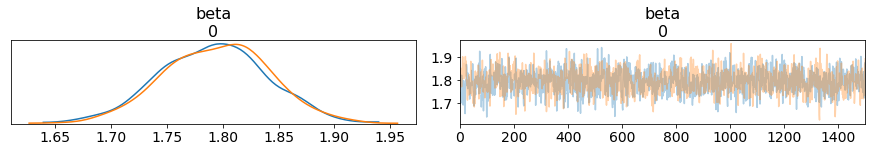

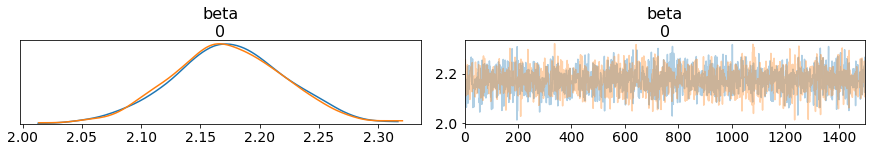

In [15]:
# Specify which models and params to check diagnostics on.
# Format: {model name: (param1, param2, param3, ...)}
# Add additional models as necessary
model_params = {'base': ('beta'),
                'mean-lake': ('beta')}

for model in model_params.keys():
        
    # Note: Easiest to use the PyStan Object directly
    tfit = fits[model]
    check_post = az.from_pystan(tfit)
    az.plot_trace(check_post, var_names=model_params[model])

## Extracting parameter estimates from models

After checking model convergence diagnostics, one can examine the model parameters.  One can use either the fitted PyStan objects or the pickled posterior distributions.  Here we use the pickled posteriors so we so we don't have to
refit the models if they are not already fit in the namespace.

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/mqwilber/anaconda3/lib/python3.6/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False
/Users/mqwilber/anaconda3/lib/python3.6/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/mqwilber/anaconda3/lib/python3.6/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2li

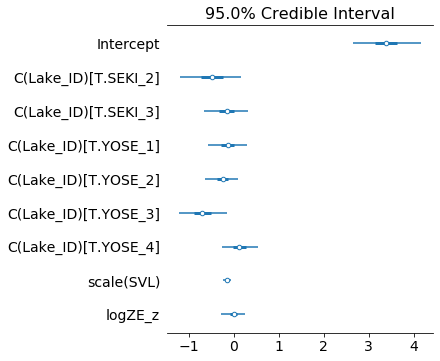

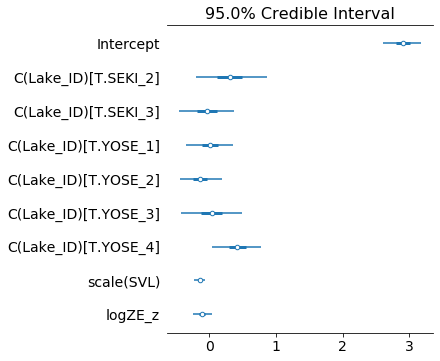

In [16]:
# Specify the models and parameters to examine
models_to_explore = {'mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd':  ['beta'],
                     'mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet': ['beta']}

# Plot the 95% CIs around the dispersal effects
for model in models_to_explore:
    
    # Load in pickled posterior
    posterior, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))
    up_dict = {nm : posterior[nm].reshape([1] + list(posterior[nm].shape)) for nm in models_to_explore[model]}
    
    # Convert to az object for easy plotting
    post_dat = az.convert_to_inference_data(up_dict)
    fig, ax = az.plot_forest(post_dat, credible_interval=.95)
    
    # Plot labels for dispersal effects...X is the dispersal design matrix
    ax[0].set_yticklabels(X.columns[::-1])

Parameters can also be extracted and examined as followed

In [17]:
for model in models_to_explore:
    
    print(model)
    posterior, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))
    print(pd.DataFrame(stats.scoreatpercentile(posterior['beta'], (2.5, 50, 97.5), axis=0).T,
                       index=X.columns, columns=['lower', 'med', 'upper']))

mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd
                         lower       med     upper
Intercept             2.610208  3.379342  4.132193
C(Lake_ID)[T.SEKI_2] -1.160463 -0.482414  0.212134
C(Lake_ID)[T.SEKI_3] -0.631984 -0.157718  0.326081
C(Lake_ID)[T.YOSE_1] -0.564430 -0.135258  0.295612
C(Lake_ID)[T.YOSE_2] -0.612059 -0.245667  0.122090
C(Lake_ID)[T.YOSE_3] -1.226364 -0.698594 -0.147700
C(Lake_ID)[T.YOSE_4] -0.289675  0.119572  0.523305
scale(SVL)           -0.237614 -0.144145 -0.050264
logZE_z              -0.265749 -0.001466  0.253879
mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet
                         lower       med     upper
Intercept             2.606591  2.899620  3.175362
C(Lake_ID)[T.SEKI_2] -0.227944  0.311924  0.844478
C(Lake_ID)[T.SEKI_3] -0.434901 -0.033929  0.391760
C(Lake_ID)[T.YOSE_1] -0.340130  0.008839  0.386130
C(Lake_ID)[T.YOSE_2] -0.435430 -0.132518  0.185768
C(Lake_ID)[T.YOSE_3] -0.422521  0.034954  0.485889
C(Lake_ID)[T.YOSE_4]  0.057631  0.420423  0.78836

## Calculting goodness-of-fit statistics for models

For improved performance, goodness-of-fit statistics are calculated in the Julia notebook "GOF_test.ipynb".
First, run the code below to re-save design matrices as Numpy arrays for easier loading into Julia.

In [40]:
# Code to enable GOF tests in Julia
for model in model_Xs.keys():
    
    print("Working on {0}".format(model))
    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))
    X = X.values
    Z = Z.values
    W = W.values
    pd.to_pickle((stanfit, standata, X, Z, W, bd_load), 
                  "../results/{0}-numOTU{1}_for_julia.pkl".format(model, num_otus))

## Calculating information criteria for fitted models

For model comparison, we used WAIC or PSIS-LOO. Similar to other information criteria, these are relative measures of model out-of-sample predictive performance. Lower values are "better". 

In [18]:
models = list(model_Xs.keys())

loos = {}
waics = {}
for model in model_Xs.keys():
    
    try:
        stanfit = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))[0]
        loo_res = psis.psisloo(stanfit['log_lik'])
        waic_res = psis.waic(stanfit['log_lik'])
        loos[model] = [-2*loo_res[0]]
        waics[model] = [waic_res]
    except FileNotFoundError:
        pass

# Build Delta WAIC/LOO-IC

nm = ['LOO', 'WAIC']
for i, res in enumerate([loos, waics]):
    
    model_fits = pd.DataFrame(res).T.rename(columns={0:nm[i]})
    model_fits = model_fits.round(decimals=2)
    delta_table = model_fits - model_fits.min(axis=0)
    delta_table = delta_table.assign(w=lambda x: np.exp(-0.5*x[nm[i]]) / np.sum(np.exp(-0.5*x[nm[i]])))
    delta_table = delta_table.rename({nm[i]: "Delta " + nm[i]})
    print(delta_table.round(3))

                                               LOO    w
base                                       1661.74  0.0
mean-lake                                   970.60  0.0
mean-lake_I-svl-Bd-lake                     957.89  0.0
mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd     0.00  1.0
mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet   365.45  0.0
                                              WAIC    w
base                                       1673.38  0.0
mean-lake                                   981.96  0.0
mean-lake_I-svl-Bd-lake                     968.44  0.0
mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd     0.00  1.0
mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet   365.36  0.0


WAIC and PSIS-LOO giving the same model rankings. The base netural model is clearly inferior compared to the models with selection, dispersal, and drift effects. The best model, as shown in the manuscript, is the model with selection effects and OTU-specific effects on dispersal and drift (Hypothesis 4).

## Plotting model predictions

In this section, we plot three model predictions from the field data

1. Lake-specific Bd effects on I (Community-wide)
2. OTU-specific I effects
3. OTU-specific selection effects of Bd

###  Lake-specific effects of Bd on the fundamental recruitment number I

**Key matrices**

1. `beta`: Vector of length P. P fixed effects of dispersal and drift on all OTUs. These affects on dispersal and drift are constant for all OTUs.

In [31]:
# Plot the predicted dispersal and drift effects
model = "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"
stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))
Xmat = X.values # Fixed dispersal and drift
Zmat = Z.values # Random dispersal and drift effects
Wmat = W.values # Selection effects

# Build predictive design matrix 
lake_ids = np.sort(site_dat.Lake_ID.unique())
logbd = np.log10(bd_load + 1)
pred_bd = np.linspace(np.min(logbd), np.max(logbd), num=30)
pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)
X_design = dmatrix("bd", data={'bd': pred_bd_z}, return_type="dataframe")

Text(0.5, 0, 'log10(Bd load + 1)')

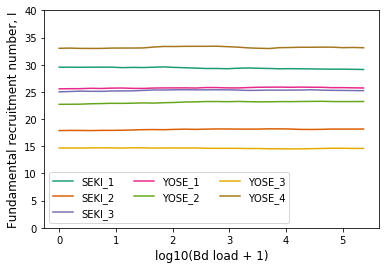

In [33]:
# Plot by lake
fig, ax = plt.subplots(1, 1)
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]

all_lake_preds = {}
betas = pd.DataFrame(stanfit['beta'], columns=X.columns) # Posteriors of dispersal and drift effects
for l, lake in enumerate(lake_ids):
    
    Bd_effect = betas.filter(like="ZE").values
    int_effects = pd.concat([betas.filter(like="Intercept"), betas.filter(like=lake)], axis=1)
    intercept = int_effects.sum(axis=1).values
    β = np.hstack([intercept[:, np.newaxis], Bd_effect]).T
    
    # Prediction for I on the log-link scale
    lake_pred = np.exp(np.dot(X_design.values, β))
    
    # Extract and plot median prediction...Can look at different percentiles of the prediction as well.
    med_pred = stats.scoreatpercentile(lake_pred, (50), axis=1)
    ax.plot(pred_bd, med_pred, color=colors[l], label=lake)

ax.set_ylim(0, 40)
ax.legend(ncol=3)
ax.set_ylabel("Fundamental recruitment number, I", size=12)
ax.set_xlabel("log10(Bd load + 1)", size=12)

### OTU-specific effects on dispersal

Extract and plot the OTU-specific differences in dispersal and drift.

**Key matrices**

1. `Omega`: Matrix has dimensions G, S. G covariates affecting dispersal and drift that can vary by OTU and each S species can have its own dispersal and drift effect.
2. `Beta`: Matrix has dimensions P, S. P predictor variables where there is a fixed effect of dispersal and drift and these *same* predictor variables are repeated for all S OTUs. These are repeated so they can easily be manipulated along with `Omega`. This is the same as `beta` repeated for all S species.

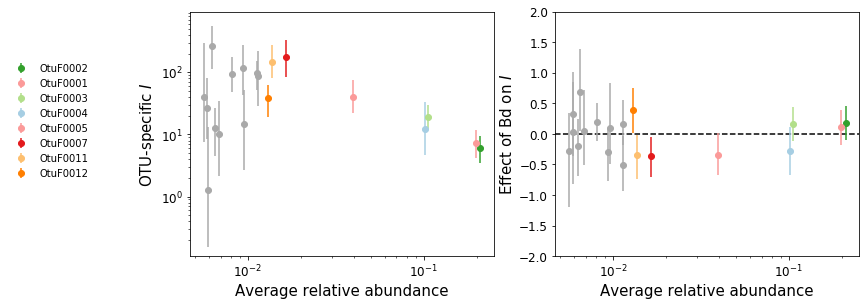

In [35]:
colors = ['#33a02c', '#fb9a99','#b2df8a','#a6cee3','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
models = ["mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=False, sharey=False)

axes = axes.ravel()
labelsize = 15
num_label_otus = 8 # The number of OTUs to label in the legend
bd_effect_col = 8 # The 0-indexed column where the Bd effect is found

for model in  models:
    
    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))
    X = X.values
    Z = Z.values
    W = W.values
    
    # Median random dispersal and drift effects for OTUs
    Ω = stats.scoreatpercentile(stanfit['Omega'], 50, axis=0)
    
    # Median fixed effects for dispersal and drift
    β = stats.scoreatpercentile(stanfit['Beta'], 50, axis=0)
    
    # Predictive values for Bd
    logbd = np.log10(bd_load + 1)
    pred_bd = np.linspace(0, np.max(logbd), num=30)
    pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)
    bd_val = (0 - np.mean(logbd)) / np.std(logbd)

    # Build fixed effect design matrix
    X = dmatrix("svl + x - 1", data={"x": pred_bd_z, "svl": np.repeat(0, len(pred_bd_z))})
    # Add six columns of zeros to account for lakes
    Xzeros = np.zeros(len(X)*6).reshape(len(X), 6)
    X = np.hstack([np.ones(len(X))[:, np.newaxis], Xzeros, X])
    
    # Build random effect design matrix
    Z = dmatrix("x", data={"x": pred_bd_z})
    
    # Predict median I on the log link 
    Is = np.exp(np.dot(X, β) + np.dot(Z, Ω))
    
    tslopes_full = []
    tints_full = []

    # Pull 500 draws from the posterior distribution to uncertainty in random effects
    rs = np.random.choice(np.arange(stanfit['Beta'].shape[0]), size=500)
    for r in rs:
        
        tΩ = stanfit['Omega'][r, :, :]
        tβ = stanfit['Beta'][r, :, :]
        
        tslopes_full.append((tβ[[0, bd_effect_col], :] + tΩ)[1, :]) # Bd effect 
        tints_full.append(np.exp(np.dot(X, tβ) + np.dot(Z, tΩ))[0, :]) # Take the prediction of I when Bd is absent
    
    # Compute uncertainthy in slope and int random effects
    tslopes = stats.scoreatpercentile(np.array(tslopes_full), (2.5, 50, 97.5), axis=0)
    tints = stats.scoreatpercentile(np.array(tints_full), (2.5, 50, 97.5), axis=0)
    
    ests = [tints, tslopes]
    
    # Plot the estimated effects
    for i in range(num_label_otus):
        
        lab = metacomm_p.index[i]
        lab = lab.replace("Otu", "OtuF")
        
        for j in range(2):
            if j == 1:
                tlab = lab
            else:
                tlab = None
                
            axes[j].errorbar([metacomm_p[i]], 
                         [ests[j][1, i]], yerr=[[ests[j][1, i] - ests[j][0, i]], 
                                                [ests[j][2, i] - ests[j][1, i]]], 
                                         marker="o", linestyle="", color=colors[i], label=tlab)

    for i in range(num_label_otus, num_otus):
        
        for j in range(2):
            
            axes[j].errorbar([metacomm_p[i]], 
                         [ests[j][1, i]], yerr=[[ests[j][1, i] - ests[j][0, i]], 
                                                [ests[j][2, i] - ests[j][1, i]]], 
                                         marker="o", linestyle="", color="#A9A9A9")
    
    
    # Some plot details
    axes[1].legend(loc=(-1.8, 0.3), frameon=False, prop={'size': 10})
    axes[1].set_xscale("log")
    axes[1].set_xlabel("Average relative abundance", size=labelsize)
    axes[1].set_ylabel("Effect of Bd on $I$", size=labelsize)
    xlim = axes[1].get_xlim()
    axes[1].hlines(0, *xlim, zorder=-5, linestyle="dashed")
    axes[1].set_xlim(xlim)
    
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")

    axes[0].set_xlabel("Average relative abundance", size=labelsize)
    axes[0].set_ylabel("OTU-specific $I$", size=labelsize)
    
    axes[0].set_ylim(0.11, 950)
    axes[1].set_ylim(-2, 2)
    
    for ax in axes:
        ax.tick_params(labelsize=12)


### Bd effects on selection

Extracting and plotting the OTU-specific Bd effects selection. In other words, the mean effects. The y-axis is given
on the logit scale: log(relative abundance / (1 - relative abundance)).

**Key matrices**

1. `Beta_meta`: Matrix has dimensions K, S. K covariates affecting selection and each S species can have its own selection effect.

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


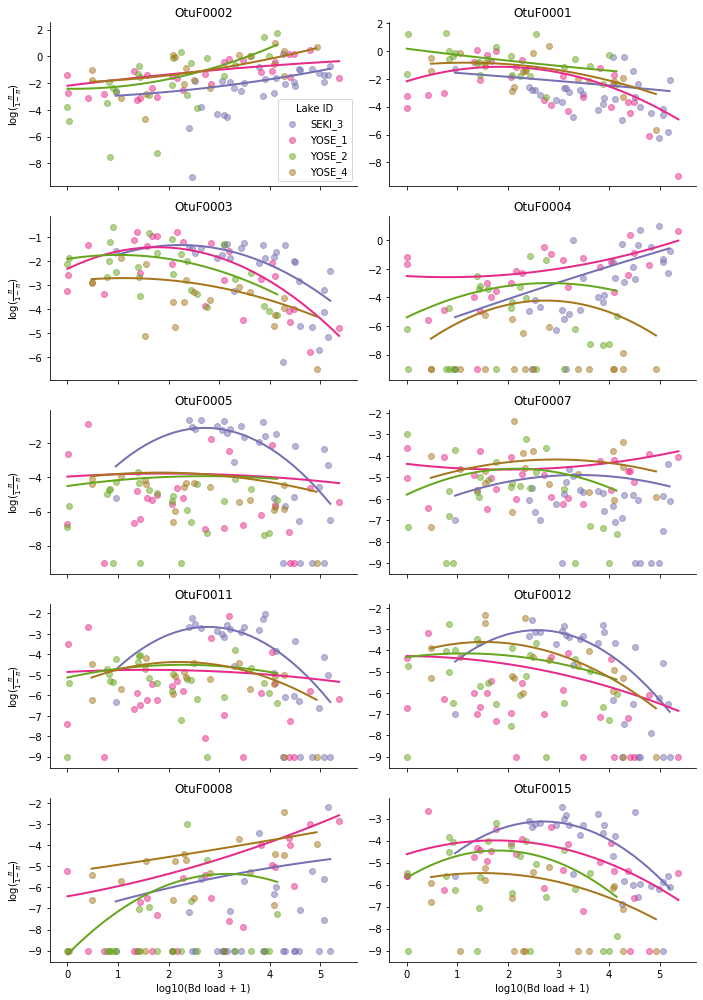

In [36]:
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]
models = ["mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"]

fig, axes = plt.subplots(5, 2, figsize=(10, 14), sharex=True, sharey=False)
axes = axes.ravel()
num_lakes = len(lake_ids)
relative_otus = (abund_otus.values.T / abund_otus.sum(axis=1).values).T
num_otus_to_plot = 10

for model in  models:

    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))
    X = X.values
    Z = Z.values
    W = W.values

    for inum, i in enumerate(range(num_otus_to_plot)):

        for l, lake in enumerate(np.sort(lake_ids)):
            
            ind = (site_dat.Lake_ID == lake).values
            
            # Build Bd predictive values
            logbd = np.log10(bd_load + 1)
            pred_bd = np.linspace(np.min(logbd[ind]), np.max(logbd[ind]), num=30)
            pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)
            
            # This bit of code is accounting for the that each lake has its own Bd selection effects.
            if l != 0:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, l, num_lakes, num_lakes + l, num_lakes*2, num_lakes*2 + l], :]
                X = dmatrix("ones + x + x1 + np.power(x, 2) + np.power(x1, 2)", data={"x": pred_bd_z, "x1": pred_bd_z, "ones": np.repeat(1, len(pred_bd_z))})
                meta_p_logit = np.dot(X, Beta_meta)
            else:
                # This is the baseline lake.
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, num_lakes, num_lakes*2], :]
                X = dmatrix("x + np.power(x, 2)", data={"x": pred_bd_z})
                meta_p_logit = np.dot(X, Beta_meta)
            
            # Just plotting four of the lakes
            if l in [2, 3, 4, 6]:
                
                ax = axes[inum]
                lab = metacomm_p.index[i]
                lab = lab.replace("Otu", "OtuF")
                
                if lab == "OtuF0007, unclassified":
                    lab = "OtuF0007, Comamonadaceae,\nunclassified"
                    
                ax.plot(pred_bd, meta_p_logit[:, i], lw=2, color=colors[l])
                ax.set_title(lab)

                ind = site_dat.Lake_ID == lake
                logpred = np.log(relative_otus[ind, i]  / (1 - relative_otus[ind, i]))
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=-1, label=lake, alpha=0.5, color=colors[l])

                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                               marker='o', zorder=5, color=colors[l], alpha=0.5)

        if ax.is_last_row():
            ax.set_xlabel("log10(Bd load + 1)")
        
        if ax.is_first_col():
            ax.set_ylabel(r"$\log(\frac{\pi}{1 - \pi})$")
        
        if inum == 0:
            ax.legend(loc="lower right", title="Lake ID", frameon=True)
        
        ax.spines['right'].set_visible(None)
        ax.spines['top'].set_visible(None)

plt.tight_layout()

In [ ]:
Building on the selection plots above, look at the effect sizes of selection.

Text(-0.05, 1.01, 'A.')

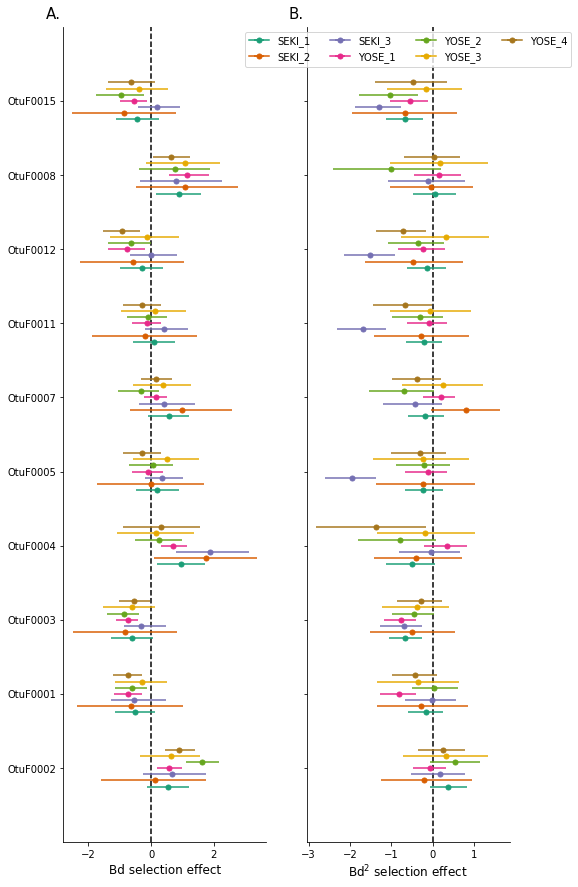

In [38]:
# Plot effect sizes for the top 10 OTUs
fig, axes = plt.subplots(1, 2, figsize=(8, 15), sharey=True)
axes = axes.ravel()
model = "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"
stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/{0}-numOTU{1}.pkl".format(model, num_otus))


num_lakes = len(lake_ids)
adjust = np.linspace(-0.5, 0.5, num=num_lakes)
otu_names = []

include_otus = 10
for otu_num in range(include_otus):
    
    otu_names.append(metacomm_p.index[otu_num])
    
    for l, lake in enumerate(np.sort(lake_ids)):
        
        if l != 0:
            l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes, num_lakes + l], otu_num].sum(axis=1), (2.5, 50, 97.5))
            l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes*2, num_lakes*2 + l], otu_num].sum(axis=1), (2.5, 50, 97.5))
        else:
            l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes], otu_num], (2.5, 50, 97.5))
            l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes*2], otu_num], (2.5, 50, 97.5))
        
        if otu_num != 0:
            axes[0].errorbar([m1], [otu_num*2 + adjust[l]], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color=colors[l])
            axes[1].errorbar([m2], [otu_num*2 + adjust[l]], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color=colors[l])
        else:
            axes[0].errorbar([m1], [otu_num*2 + adjust[l]], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color=colors[l])
            axes[1].errorbar([m2], [otu_num*2 + adjust[l]], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color=colors[l],  label=lake)

for ax in axes:
    ax.vlines(0, -2, include_otus*2, zorder=-2, linestyle='--')
    ax.set_yticks(np.arange(include_otus*2, step=2))
    
    if ax.is_first_col():
        totus = np.array(otu_names).astype('<U50')
        totus = [totu.replace("Otu", "OtuF") for totu in totus]
        ax.set_yticklabels(totus, rotation=0)
        #ax.yaxis.set_tick_params(horizontalalignment="center")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
axes[0].set_ylim(-2, include_otus*2)
axes[0].set_xlabel("Bd selection effect", size=12)
axes[1].set_xlabel("Bd$^2$ selection effect", size=12)
axes[1].legend(loc="upper center", ncol=4, frameon=True)
axes[1].text(-0.05, 1.01, "B.", size=15, ha="center", transform=axes[1].transAxes)
axes[0].text(-0.05, 1.01, "A.", size=15, ha="center", transform=axes[0].transAxes)
